<a href="https://colab.research.google.com/github/dtoralg/INESDI_Data-Science_ML_IA/blob/main/%5B06%5D%20-%20Deep%20Learning/CNN_CIFAR10_step_by_step.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# CNN paso a paso con CIFAR-10 (nivel básico)
**Objetivo:** construir, entrenar y evaluar una red neuronal convolucional (CNN) usando el dataset CIFAR-10, con código *secuencial*


## 0) Import Librerias

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Semillas para reproducibilidad "básica"
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow:", tf.__version__)
print("GPU disponible:", tf.config.list_physical_devices('GPU'))


TensorFlow: 2.19.0
GPU disponible: []


## 1) Cargar el dataset
* CIFAR-10 contiene 60.000 imágenes 32x32 en color (RGB) de 10 clases de objetos.
* 50.000 para entrenamiento y 10.000 para test.
* Las etiquetas son enteros (0..9). Usaremos 'sparse_categorical_crossentropy' para no hacer one-hot.

In [2]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 'y_train' y 'y_test' vienen con forma (n, 1). Aplanamos a (n,) para comodidad.
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)
print("x_test  shape:", x_test.shape,  "y_test  shape:", y_test.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
x_train shape: (50000, 32, 32, 3) y_train shape: (50000,)
x_test  shape: (10000, 32, 32, 3) y_test  shape: (10000,)


## 2) Visualizacion de datos
* Mostramos algunas imágenes del set de entrenamiento con su etiqueta (nombre de clase).

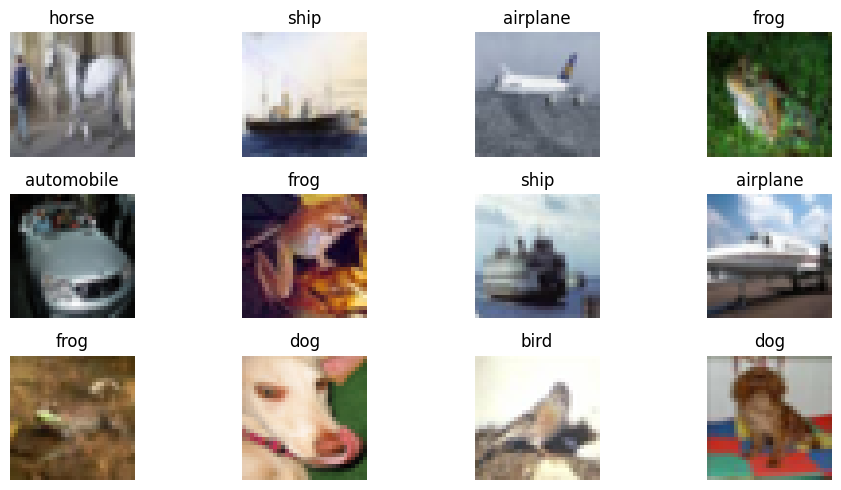

In [3]:
plt.figure(figsize=(10, 5))
num_to_show = 12  # cuántas imágenes mostrar
indices = np.arange(x_train.shape[0])
np.random.shuffle(indices)
indices = indices[:num_to_show]

for i, idx in enumerate(indices):
    plt.subplot(3, 4, i + 1)
    plt.imshow(x_train[idx])
    plt.title(class_names[y_train[idx]])
    plt.axis("off")

plt.tight_layout()
plt.show()

## 3) Preprocesado Sencillo

In [4]:
# Normalizamos los píxeles a rango [0,1] dividiendo entre 255.0.
# Además, separamos un pequeño conjunto de validación del entrenamiento.

x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# Creamos un conjunto de validación a partir del final del entrenamiento.
# Por ejemplo, 5.000 muestras para validación.
val_size = 5000
x_val = x_train[-val_size:]
y_val = y_train[-val_size:]
x_train = x_train[:-val_size]
y_train = y_train[:-val_size]

print("x_train:", x_train.shape, "| x_val:", x_val.shape, "| x_test:", x_test.shape)

x_train: (45000, 32, 32, 3) | x_val: (5000, 32, 32, 3) | x_test: (10000, 32, 32, 3)


## 4) Definimos el Modelo CNN

In [5]:
# Usamos un modelo secuencial con bloques Conv2D + MaxPooling,
# seguido de Flatten y capas densas. Mantendremos el modelo **simple**.

model = keras.Sequential()

# Bloque 1: Convoluciones + MaxPooling
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding="same", input_shape=(32, 32, 3)))
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2,2)))  # reduce a 16x16

# Bloque 2
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="same"))
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2,2)))  # reduce a 8x8

# Bloque 3 (opcional pero pequeño)
model.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2,2)))  # reduce a 4x4

# Aplanado + densas
model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.5))  # ayuda a evitar sobreajuste de forma sencilla
model.add(layers.Dense(10, activation="softmax"))  # 10 clases

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 402,986 (1.54 MB)

 Trainable params: 402,986 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

## 5) Compilamos el modelo

In [6]:
# - Optimizador: Adam (buena opción por defecto)
# - Pérdida: sparse_categorical_crossentropy (etiquetas enteras 0..9)
# - Métrica: accuracy

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


## 6) Entrenamos el Modelo CNN

In [7]:
# Ajusta epochs según tu tiempo/recursos. Con 5 ya se ve que aprende.
# batch_size 64 es una elección común.
#704 es el lote de entrenamiento, sale de: ceil(n_muestras_entrenamiento / batch_size), n_muestras = 45.000 el train en nuestro caso / batch_size = 64 = 704

epochs = 5
batch_size = 64 #Batch Size cuántas muestras procesa el modelo antes de actualizar los pesos, 64 número de imágenes que el modelo procesa juntas antes de hacer una actualización de pesos

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

Epoch 1/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 271s 381ms/step - accuracy: 0.2819 - loss: 1.9134 - val_accuracy: 0.5248 - val_loss: 1.2900
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 328s 390ms/step - accuracy: 0.5239 - loss: 1.3146 - val_accuracy: 0.6438 - val_loss: 1.0074
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 277s 393ms/step - accuracy: 0.6203 - loss: 1.0796 - val_accuracy: 0.6950 - val_loss: 0.8988
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 274s 389ms/step - accuracy: 0.6756 - loss: 0.9326 - val_accuracy: 0.6878 - val_loss: 0.8742
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 309s 370ms/step - accuracy: 0.7101 - loss: 0.8186 - val_accuracy: 0.7448 - val_loss: 0.7476


## 7) Curva de entrenamiento y curva de validación

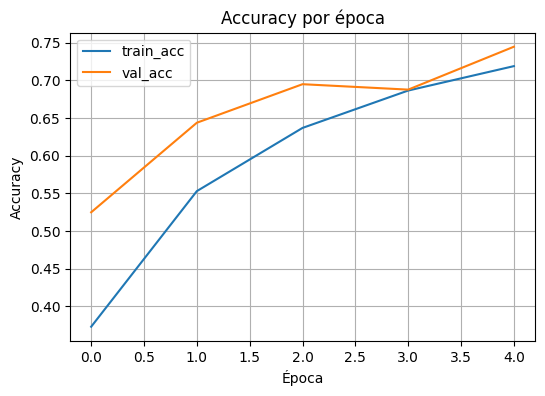

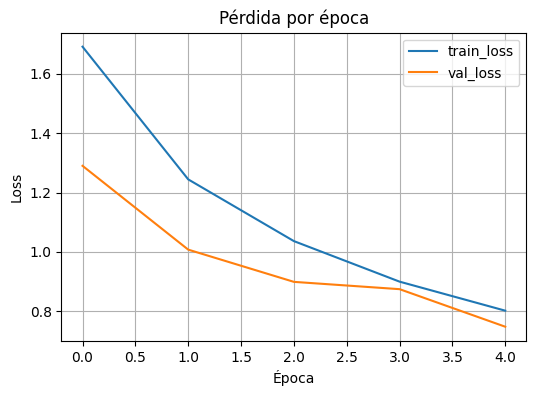

In [8]:
# Usamos matplotlib (sin seaborn) y un gráfico por métrica (requisito del entorno).

# Accuracy
plt.figure(figsize=(6,4))
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Accuracy por época")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Pérdida
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Pérdida por época")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


## 8) Evaluación en trest final

In [9]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Loss en test: {test_loss:.4f}")
print(f"Accuracy en test: {test_acc:.4f}")

Loss en test: 0.7765
Accuracy en test: 0.7315


## 9) Predicciones y visualizacion final

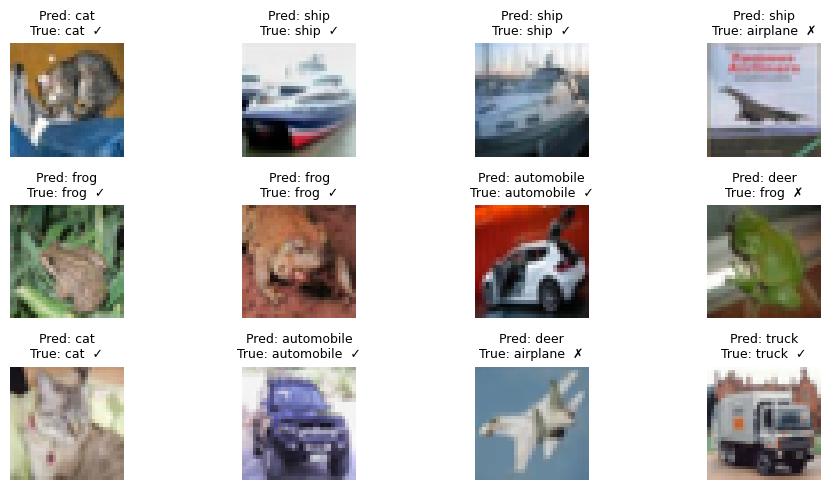

In [10]:
# Mostramos una cuadrícula con imágenes del test, la etiqueta real y la predicción.
# Esto ayuda a "ver" lo que hace la red.

num_examples = 12
imgs = x_test[:num_examples]
true_labels = y_test[:num_examples]

# Predict devuelve probabilidades para cada clase; tomamos el índice con mayor probabilidad.
probs = model.predict(imgs, verbose=0)
pred_labels = np.argmax(probs, axis=1)

plt.figure(figsize=(10, 5))
for i in range(num_examples):
    plt.subplot(3, 4, i + 1)
    plt.imshow(imgs[i])
    pred_name = class_names[pred_labels[i]]
    true_name = class_names[true_labels[i]]
    title = f"Pred: {pred_name}\nTrue: {true_name}"
    # Indicamos si acierta o no
    if pred_labels[i] == true_labels[i]:
        title += "  ✓"
    else:
        title += "  ✗"
    plt.title(title, fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()



## Ideas para seguir mejorando (You DO)
- Aumentar `epochs` para mejorar la precisión (con más tiempo de entrenamiento). Cuidado tarda tiempo en entrenar el modelo
- Añadir una **matriz de confusión** y métricas por clase.
- Ajustar la arquitectura (más/menos filtros, capas, *Dropout*).
- Probar optimizadores o tasas de aprendizaje distintas.



## 10) EXTRA- Matriz de confusión y metricas por clase

=== Classification report (por clase) ===
              precision    recall  f1-score   support

    airplane     0.8047    0.7580    0.7806      1000
  automobile     0.9163    0.8430    0.8781      1000
        bird     0.6654    0.5370    0.5944      1000
         cat     0.5976    0.4530    0.5154      1000
        deer     0.5895    0.7540    0.6617      1000
         dog     0.6539    0.6160    0.6344      1000
        frog     0.8192    0.7750    0.7965      1000
       horse     0.6435    0.8320    0.7257      1000
        ship     0.8130    0.8910    0.8502      1000
       truck     0.8417    0.8560    0.8488      1000

    accuracy                         0.7315     10000
   macro avg     0.7345    0.7315    0.7286     10000
weighted avg     0.7345    0.7315    0.7286     10000



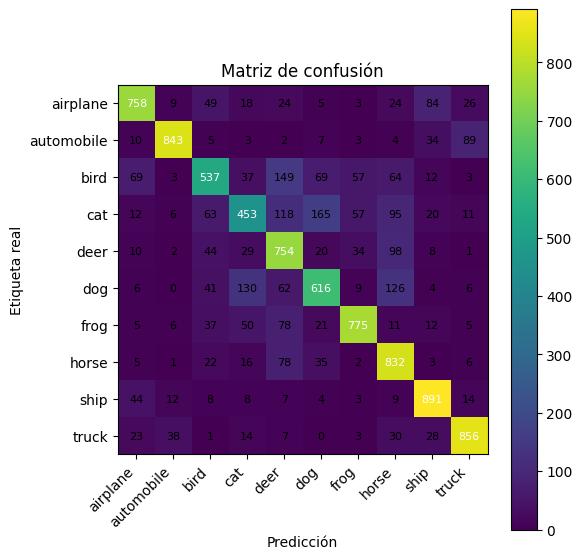

Accuracy clase 'airplane': 0.7580
Accuracy clase 'automobile': 0.8430
Accuracy clase 'bird': 0.5370
Accuracy clase 'cat': 0.4530
Accuracy clase 'deer': 0.7540
Accuracy clase 'dog': 0.6160
Accuracy clase 'frog': 0.7750
Accuracy clase 'horse': 0.8320
Accuracy clase 'ship': 0.8910
Accuracy clase 'truck': 0.8560


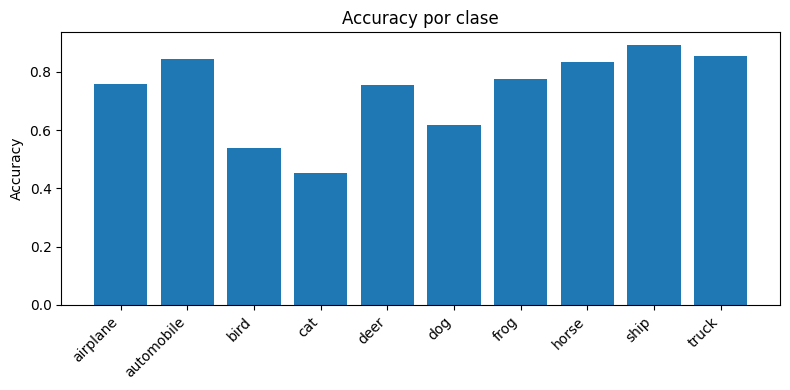

In [11]:
# Usamos el modelo que quieras evaluar (model, model_aug, model_tuned, etc.)
# Aquí uso "model" como ejemplo.

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# 1) Predicciones en test
probs_test = model.predict(x_test, batch_size=???, verbose=0) #batch_size ....128
y_pred = np.argmax(probs_test, axis=1)

# 2) Informe por clase (precision, recall, f1)
print("=== Classification report (por clase) ===")
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

# 3) Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation="nearest")
plt.title("Matriz de confusión")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)
# Anotamos los números en cada celda
th = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]),
                 ha="center", va="center",
                 color="white" if cm[i, j] > th else "black", fontsize=8)
plt.tight_layout()
plt.show()

# 4) (Opcional) accuracy por clase
class_acc = []
for c in range(len(class_names)):
    idx = (y_test == c)
    acc_c = (y_pred[idx] == y_test[idx]).mean()
    class_acc.append(acc_c)
    print(f"Accuracy clase '{class_names[c]}': {acc_c:.4f}")

# 5) (Opcional) gráfico de barras con accuracy por clase
plt.figure(figsize=(8,4))
plt.bar(np.arange(len(class_names)), class_acc)
plt.xticks(np.arange(len(class_names)), class_names, rotation=45, ha="right")
plt.ylabel("Accuracy")
plt.title("Accuracy por clase")
plt.tight_layout()
plt.show()


## 11) EXTRA- Pruebas de arquitectura

In [ ]:
# Añadimos BatchNormalization, algo más de capacidad y L2
# para regularizar. Es un NUEVO modelo (model_tuned).

from tensorflow import keras
from tensorflow.keras import layers, regularizers

weight_decay = 1e-4

model_tuned = keras.Sequential()

# Bloque 1
model_tuned.add(layers.Conv2D(32, (3,3), padding="same", kernel_regularizer=regularizers.l2(weight_decay),input_shape=(32,32,3)))
model_tuned.add(layers.BatchNormalization())
model_tuned.add(layers.ReLU())
model_tuned.add(layers.Conv2D(32, (3,3), padding="same",kernel_regularizer=regularizers.l2(weight_decay)))
model_tuned....   #añade capa basica de BatchNormalization
model_tuned..... #añade capa estandar activada por Relu
model_tuned..... #añade capa de MaxPolling 2,2
model_tuned....     #dropout 25%

# Bloque 2
model_tuned.add(layers.Conv2D(64, (3,3), padding="same",kernel_regularizer=regularizers.l2(weight_decay)))
model_tuned....   #añade capa basica de BatchNormalization
model_tuned..... #añade capa estandar activada por Relu
model_tuned.add(layers.Conv2D(64, (3,3), padding="same", kernel_regularizer=regularizers.l2(weight_decay)))
model_tuned....   #añade capa basica de BatchNormalization
model_tuned..... #añade capa estandar activada por Relu
model_tuned.add(layers.MaxPooling2D((2,2)))
model_tuned.add(layers.Dropout(0.25))

# Cabeza
model_tuned..... #Flateen


model_tuned.add(layers.Dense(256, activation="relu"))
model_tuned.....   #dropout 50%

#Salida
model_tuned.add(layers.Dense(10, activation="softmax"))

model_tuned.compile(optimizer="adam",
                    loss="sparse_categorical_crossentropy",
                    metrics=["accuracy"])

history_tuned = model_tuned.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=????, #epochs quizas 12
    batch_size=????,  #batch_size quizas 64
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/12
704/704 ━━━━━━━━━━━━━━━━━━━━ 316s 443ms/step - accuracy: 0.2527 - loss: 2.1998 - val_accuracy: 0.4100 - val_loss: 1.6213
Epoch 2/12
704/704 ━━━━━━━━━━━━━━━━━━━━ 309s 440ms/step - accuracy: 0.3927 - loss: 1.6170 - val_accuracy: 0.5414 - val_loss: 1.2968
Epoch 3/12
704/704 ━━━━━━━━━━━━━━━━━━━━ 312s 444ms/step - accuracy: 0.4459 - loss: 1.4795 - val_accuracy: 0.6042 - val_loss: 1.1505
Epoch 4/12
704/704 ━━━━━━━━━━━━━━━━━━━━ 315s 447ms/step - accuracy: 0.4921 - loss: 1.3726 - val_accuracy: 0.6162 - val_loss: 1.1156
Epoch 5/12
704/704 ━━━━━━━━━━━━━━━━━━━━ 313s 445ms/step - accuracy: 0.5162 - loss: 1.3053 - val_accuracy: 0.6346 - val_loss: 1.0586
Epoch 6/12
704/704 ━━━━━━━━━━━━━━━━━━━━ 311s 442ms/step - accuracy: 0.5452 - loss: 1.2416 - val_accuracy: 0.6302 - val_loss: 1.1370
Epoch 7/12
704/704 ━━━━━━━━━━━━━━━━━━━━ 323s 444ms/step - accuracy: 0.5722 - loss: 1.1782 - val_accuracy: 0.6480 - val_loss: 1.0492
Epoch 8/12
704/704 ━━━━━━━━━━━━━━━━━━━━ 314s 432ms/step - accuracy: 0.5914 -

## 12) EXTRA Probar optimizadores o tasas de aprendizaje distintas

In [ ]:
# Ejemplo con SGD + momentum (más "clásico") y un programador de LR.
# También añadimos EarlyStopping para evitar sobreentrenar.

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Opción A: SGD con momentum y Nesterov
opt = SGD(learning_rate=0.05, momentum=0.9, nesterov=True)

# Opción B: Adam con LR distinto
# opt = Adam(learning_rate=0.0005)

# Callbacks útiles:

# baja la tasa de aprendizaje (LR) automáticamente cuando la métrica que vigila deja de mejorar (“se estanca”).
lr_plateau = ReduceLROnPlateau(monitor="val_accuracy", factor=???, patience=???, min_lr=1e-5, verbose=1)  #cuando hay estancamiento, multiplica la LR por 0.5, cuántas épocas seguidas sin mejora 2

early_stop = EarlyStopping(monitor="val_accuracy", patience=????, restore_best_weights=????, verbose=1) #cuántas épocas seguidas sin mejora 5, manten los pesos del ultimo modelo que mejora True

# Creamos un modelo sencillo para probar el optimizador (o reutiliza tu arquitectura favorita)
model_opt = keras.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", padding="same", input_shape=(32,32,3)),

    layers...... #añade capa de MaxPolling 2,2

    layers.Conv2D(64, (3,3), activation="relu", padding="same"),

    layers...... #añade capa de MaxPolling 2,2

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(10, activation="softmax")
])

model_opt.compile(optimizer=opt,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

history_opt = model_opt.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=15,
    batch_size=64,
    callbacks=[lr_plateau, early_stop],
    verbose=1
)
